<a href="https://colab.research.google.com/github/ulissigroup/amptorch/blob/active_learning/amptorch/active_learning/examples/oal_relaxation_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install  -q git+https://github.com/ulissigroup/amptorch.git@active_learning
!pip install -q git+https://github.com/mshuaibii/SIMPLE-NN.git
!pip install -q amp-atomistics
!pip install -q --upgrade dftbook

     |████████████████████████████████| 296kB 2.8MB/s 
     |████████████████████████████████| 6.7MB 6.0MB/s 
     |████████████████████████████████| 102kB 10.4MB/s 
     |████████████████████████████████| 2.1MB 44.1MB/s 
     |████████████████████████████████| 12.8MB 238kB/s 
     |████████████████████████████████| 110.5MB 59kB/s 
     |████████████████████████████████| 3.8MB 29.1MB/s 
     |████████████████████████████████| 512kB 37.4MB/s 
  ERROR: Failed building wheel for simple-nn
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
    Running setup.py install for simple-nn ... 

In [0]:
import multiprocessing as mp
import copy
import numpy as np

import ase
from ase.calculators.emt import EMT
from ase.build import fcc100, add_adsorbate, molecule
from ase.constraints import FixAtoms
from ase.optimize import BFGS, QuasiNewton

import torch

from amptorch.model import CustomMSELoss
from amptorch.active_learning.atomistic_methods  import MDsimulate, Relaxation
from amptorch.active_learning.oal_calc  import AMPOnlineCalc

import dftbook
dftbook.setup_colab()
from espresso import Espresso
from ase.utils.eos import EquationOfState
from ase.build import bulk
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
%matplotlib inline

Please be patient. This takes about 30 seconds.
Installing ASE
Installing ase-espresso
Installing pseudopotentials
Renaming pseudopotentials
Almost there, setting environment pseudopotential path
Installing MKL
Getting the GPU pw.x executable
Done installing GPU version of Quantum Espresso
Setup is complete. Please visit https://github.com/jkitchin/dft-book-espresso to find the tutorials.
Installation took 33.3 seconds


/usr/local/lib/python3.6/dist-packages/ase/utils/eos.py:5: UserWarning: Moved to ase.eos
  warnings.warn('Moved to ase.eos')


In [0]:
def get_structure(base_calc):
    energies = []
    volumes = []
    LC = [3.5, 3.55, 3.6, 3.65, 3.7, 3.75]

    for a in LC:
      cu_bulk = bulk('Cu', 'fcc', a=a)

      calc = Espresso(xc='PBE',
                  pw=500,
                  calculation='scf',
                  kpts=[12, 12, 12])
      cu_bulk.set_calculator(calc)

      e = cu_bulk.get_potential_energy()
      energies.append(e)
      volumes.append(cu_bulk.get_volume())


    eos = EquationOfState(volumes, energies)
    v0, e0, B = eos.fit()
    aref=3.6
    vref = bulk('Cu', 'fcc', a=aref).get_volume()

    copper_lattice_constant = (v0/vref)**(1/3)*aref

    slab = fcc100("Cu", a=copper_lattice_constant, size=(2, 2, 3))
    ads = molecule("C")
    add_adsorbate(slab, ads, 2, offset=(1, 1))
    cons = FixAtoms(
      indices=[atom.index for atom in slab if (atom.tag == 3)]
    )
    slab.set_constraint(cons)
    slab.center(vacuum=13.0, axis=2)
    slab.set_pbc(True)
    slab.wrap(pbc=[True] * 3)
    slab.set_calculator(copy.copy(base_calc))
    slab.set_initial_magnetic_moments()

    return slab

In [0]:
  def main():
    base_calc = Espresso(pw=500.0, 
              calculation='scf',
              kpts=(4, 4, 1),
              xc='PBE')
    
    slab = get_structure(base_calc)

    Gs = {}
    Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=4)
    Gs["G2_rs_s"] = [0] * 4
    Gs["G4_etas"] = [0.005]
    Gs["G4_zetas"] = [1.0, 4.0]
    Gs["G4_gammas"] = [+1.0, -1]
    Gs["cutoff"] = 5.876798323827276  # EMT asap_cutoff: False

    images = [slab]

    morse_params = {
      "C": {"re": 1.285943211152638, "D": 8.928283649952903, "sig": 0.9196510563637573},
      "Cu": {"re": 2.2178539292118344, "D": 2.774711971071156, "sig": 1.7173014349824842},
    }

    training_params = {
      "uncertain_tol": 0.05,
      "Gs": Gs,
      "morse": True,
      "morse_params": morse_params,
      "forcetraining": True,
      "cores": 3,
      "optimizer": torch.optim.LBFGS,
      "batch_size": 1000,
      "criterion": CustomMSELoss,
      "num_layers": 3,
      "num_nodes": 20,
      "force_coefficient": 0.04,
      "learning_rate": 1e-1,
      "epochs": 300,
      "test_split": 0,
      "shuffle": False,
      "filename": "oal_test",
      "verbose": 0
    }

    structure_optim = Relaxation(slab, BFGS, fmax=0.05, steps=50)
    online_calc = AMPOnlineCalc(parent_dataset=images, parent_calc=base_calc, n_ensembles=5, n_cores=2, training_params=training_params)
    structure_optim.run(online_calc, filename='relax_oal')

    # Calculate true relaxation
    true_relax = Relaxation(slab, BFGS)
    true_relax.run(copy.copy(base_calc), 'true_relax')
    parent_calc_traj = true_relax.get_trajectory('true_relax', 0, -1, 1)
    n_parent_calls = online_calc.parent_calls
    final_oal_traj = ase.io.read("./relax_oal.traj", ":")

    # Visualize Results

    # Calculate true relaxation
    parent_calc_traj = true_relax.get_trajectory('true_relax', 0, -1, 1)
    n_parent_calls = online_calc.parent_calls
    final_oal_traj = ase.io.read("./relax_oal.traj", ":")

    #Compute ML predicted energies
    ml_relaxation_energies = [image.get_potential_energy() for image in final_oal_traj]
    #Compute actual (DFT) energies for ML predicted structures
    dft_evaluated_ml_energies = [copy.copy(base_calc).get_potential_energy(image) for image in final_oal_traj]
    #Compute actual energies for EMT relaxation structures
    dft_relaxation_energies = [image.get_potential_energy() for image in parent_calc_traj]
    ml_steps = range(len(final_oal_traj))
    dft_steps = range(len(parent_calc_traj))

    plt.plot(ml_steps, ml_relaxation_energies, '--b', label='OAL_relaxation')
    plt.plot(ml_steps, dft_evaluated_ml_energies, '-g', label='DFT@OAL_relaxation')
    plt.plot(dft_steps, dft_relaxation_energies, '-r', label='DFT_relaxation')
    plt.xlabel("Steps")
    plt.ylabel("Energy, eV")
    plt.title('OAL vs DFT Relaxation')
    plt.legend()
    plt.show()

    def compute_loss(a, b):
      return np.mean(np.sqrt(np.sum((a - b)**2, axis=1)))

    initial_structure = images[0].positions
    print(f'Number of OAL steps: {len(final_oal_traj)}\nTotal # of queries (DFT calls): {n_parent_calls} \n')
    print(f"Final OAL Relaxed Energy: {ml_relaxation_energies[-1]}")
    print(f'DFT evaluation at AL structure: {dft_evaluated_ml_energies[-1]}\n')
    al_relaxed_structure = final_oal_traj[-1].positions

    print(f'Total number of DFT steps: {len(dft_relaxation_energies)}')
    print(f'Final DFT Relaxed Energy: {dft_relaxation_energies[-1]}\n')
    dft_relaxed_structure = parent_calc_traj[-1].positions


    initial_structure_error = compute_loss(initial_structure, dft_relaxed_structure)
    relaxed_structure_error = compute_loss(al_relaxed_structure, dft_relaxed_structure)

    print(f'Initial structure error: {initial_structure_error}')
    print(f'AL relaxed structure error: {relaxed_structure_error}')

      Step     Time          Energy         fmax
BFGS:    0 21:02:57   -66070.351562        2.8550
BFGS:    1 21:02:57   -66070.515625        2.2924
BFGS:    2 21:02:58   -66070.609375        1.5799
BFGS:    3 21:08:41   -66070.760420        1.5630
BFGS:    4 21:14:11   -66070.819587        0.6050
BFGS:    5 21:21:33   -66070.839749        0.6152
BFGS:    6 21:26:59   -66070.864411        0.7246
BFGS:    7 21:31:19   -66070.886815        0.6184
BFGS:    8 21:31:19   -66070.914062        0.4700
BFGS:    9 21:35:33   -66070.918552        0.3228
BFGS:   10 21:35:34   -66070.968750        0.2606
BFGS:   11 21:39:58   -66070.943714        0.3403
BFGS:   12 21:39:58   -66070.976562        0.1854
BFGS:   13 21:39:59   -66070.976562        0.0741
BFGS:   14 21:39:59   -66070.984375        0.0673
BFGS:   15 21:39:59   -66070.976562        0.1447
BFGS:   16 21:40:00   -66070.984375        0.0542
BFGS:   17 21:40:00   -66070.984375        0.0478
      Step     Time          Energy         fmax
BF

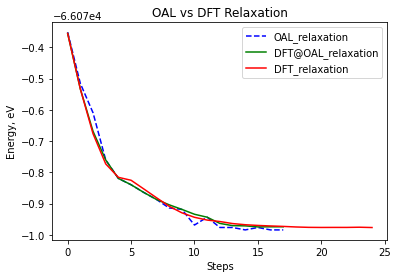

Number of OAL steps: 18
Total # of queries (DFT calls): 7 

Final OAL Relaxed Energy: -66070.984375
DFT evaluation at AL structure: -66070.9743148228

Total number of DFT steps: 25
Final DFT Relaxed Energy: -66070.97672547949

Initial structure error: 0.07725755396280275
AL relaxed structure error: 0.009875360565910025


In [0]:
if __name__ == "__main__":
  try:
    mp.set_start_method("spawn")
  except:
    if mp.get_start_method() == "spawn":
      pass
    else:
      raise Exception('Wrong mp start method!')
  main()